In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
# os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
# os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
# os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.statistics import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm
import seaborn
import pickle
from copy import deepcopy
from timeit import default_timer as timer
plt.style.use('ggplot')

# Detect static yaw with regression models

# Load Data

In [2]:
turbines = [f'/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE01_scada_high_frequency.parquet',
            f'/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet']
df_dict = {}

for i, t in enumerate(turbines):
    dataset_file = t
    df_temp = load_df(dataset_file)
    df_temp = df_temp.dropna(axis=1, how='all')
    df_temp.columns = df_temp.columns.str.replace('cor. ', '', regex=False)
    cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
            'nacelle direction', 'wind direction']
    df_temp = df_temp[cols]
    key = f"{i+1}/" + os.path.basename(t)
    df_dict[key] = df_temp
    print(f"Data from turbine {key} loaded.")

Data from turbine 1/BEBEZE01_scada_high_frequency.parquet loaded.
Data from turbine 2/BEBEZE02_scada_high_frequency.parquet loaded.


# Resample and apply filters

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Filter Complete
Filter Complete


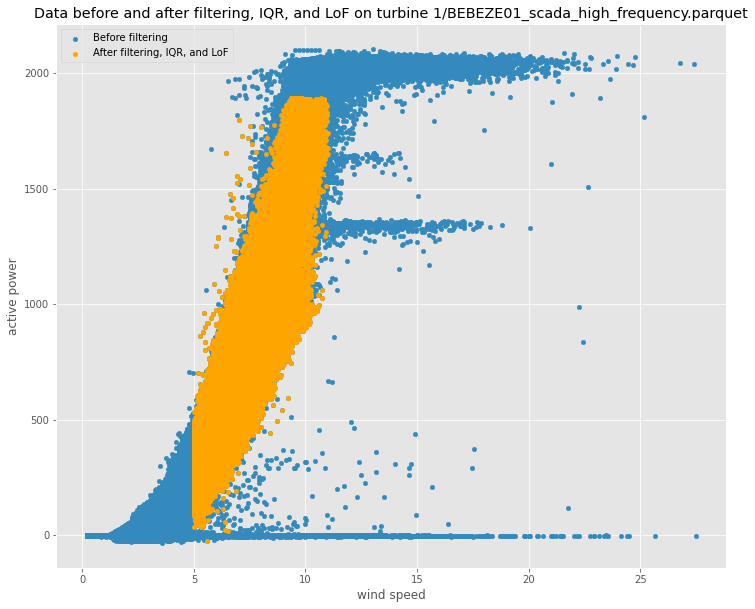

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Filter Complete
Filter Complete


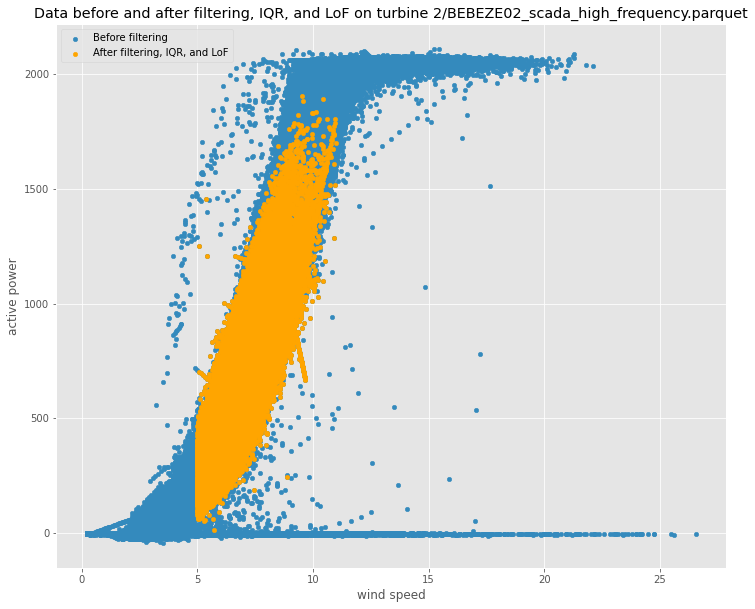

In [3]:
granularity = '1min'
for t, df in df_dict.items():
    # Resample with 60second granularity
    df=change_granularity(df,granularity=granularity)

    # calculate dynamic yaw misalignment and take a 60-min rolling mean
    df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
    df["theta_d"][df["theta_d"] > +180] -= 360
    df["theta_d"][df["theta_d"] < -180] += 360
    df["theta_d"] = df["theta_d"].rolling(60).mean()
    df = df.dropna()

    df_initial = df.copy()

    # Perform IQR outlier removal
    df = outliers_IQR(df)

    # drop values of wind speed under 5m/s
    df=filter_col(df, 0, less_than=5, bigger_than=11)

    # drop values with pitch angle higher than 2 degrees or lower than -2 degrees
    df=filter_col(df, 1, less_than=-2, bigger_than=2)

    # drop values of rotor speed under 8rpm
    df=filter_col(df, 2, less_than=8, bigger_than=15)

    # drop values of power near the power_limit and near or below zero
    
    power_limit = 2050
    df=filter_col(df, 4, less_than=1e-4, bigger_than= 1 * power_limit)


    # Keep only dates with lidar measurements
    start = '2018-06-02'
    end = '2019-01-11'
    df = filter_dates(df, start, end)
    
    # Remove Outliers using LoF
    # df = outliers_LoF(df, n_neighbors=20).copy()
    
    # Add resulting dataframe to the dict of all dataframes
    df_dict[t] = df
    
    # Uncomment for plots
    ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
    df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
    plt.title(f"Data before and after filtering, IQR, and LoF on turbine {t}")
    plt.show()

In [4]:
# Scale the datasets to 0-1 using minmax scaling
df_scaled_dict = {}
scaler = create_scaler(list(df_dict.values()))

test_list = []
for t, df in df_dict.items():
    df_scaled = df.copy()
    df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
    df_scaled_dict[t] = df_scaled
# save the scaling parameters to be used on test data 
with open('select_bins_scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file, protocol=pickle.HIGHEST_PROTOCOL)

## Add a column with the measured static yaw misalignment to each dataframe
The observed gap is data with inconsistent labels

Static Yaw angles: [-6.7, 4.8, 9.4, 0.0, 0.0]


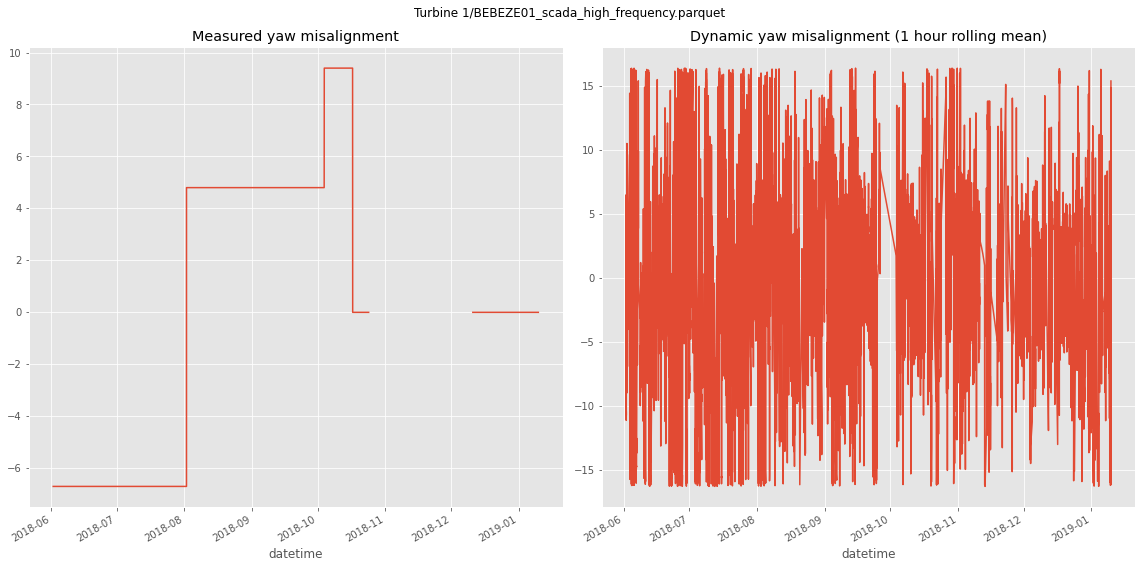

Static Yaw angles: [2.7, 2.7, 4.9, 0.0, 0.0]


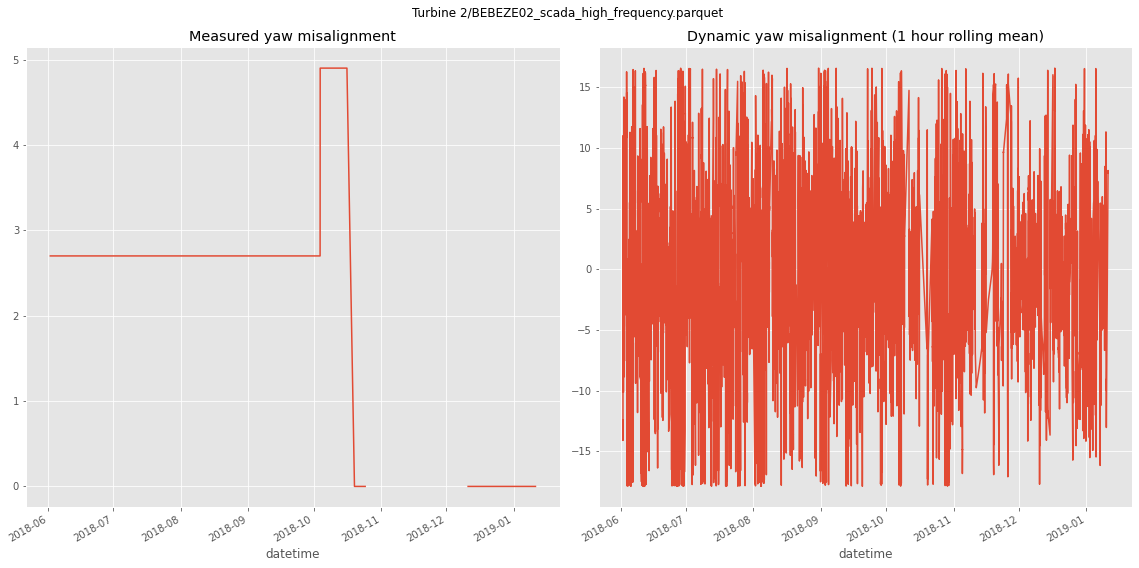

In [5]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df_angles_dict = {}
for i, t in enumerate(turbines):
    key = f"{i+1}/" + os.path.basename(t)
    df_turbine = df_dict[key]
    df_turbine["y"] = np.nan
    df_l = df_labels[df_labels.Turbines == t]
    for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
        df_turbine.loc[start:end, 'y'] = static
    df_angles_dict[key] = list(df_l.StaticYaw.values)
    print(f"Static Yaw angles: {df_angles_dict[key]}")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plt.suptitle(f'Turbine {key}')

    ax1 = df_turbine['y'].plot(ax=axs[0])
    ax1.set_title(f"Measured yaw misalignment")

    ax2 = df_turbine['theta_d'].plot(ax=axs[1])
    ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
    plt.tight_layout()
    plt.show()

## Split each turbine dataset in wind speed bins

In [6]:
df_bin_masks = {}
bin_size = 0.5
min_speed = 5
max_speed = 11
bin_feature = 'wind speed'
for t, df in df_dict.items():
    df_bin_masks[t] = split_to_bins(df, bin_size, min_speed, max_speed, bin_feature)


- set manually_select to True to bypass Lasso and use manual_feats as the selected features
- In this case we are going to use the selected Features.

In [7]:
features = ['wind speed', 'pitch angle', 'rotor speed', 'nacelle direction', 'wind direction', 'theta_d']
target = 'active power'
df_selected_feats = {}
manually_select = False
manual_feats = ['wind speed']
for t, df in df_scaled_dict.items():
    if manually_select:
        selected_features = manual_feats
    else:
        selected_features = lasso_selection(df, features, target)
    df_selected_feats[t] = selected_features
    print(f'The selected features for {t} are: {selected_features}')

The selected features for 1/BEBEZE01_scada_high_frequency.parquet are: ['wind speed', 'pitch angle', 'rotor speed', 'nacelle direction', 'wind direction']
The selected features for 2/BEBEZE02_scada_high_frequency.parquet are: ['wind speed', 'pitch angle', 'rotor speed', 'wind direction', 'theta_d']


## Define the regression method and the parameter search space


In [8]:
# Definition of the regression model (or pipeline) that will be used for the rest of the experiments
model = Ridge(solver='lsqr')
polynomial_features = PolynomialFeatures()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("regression", model)])
#Changed the top polynomial degree with 3
parameters = {'regression__alpha':[0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
              'polynomial_features__degree':list(range(1, 4))}

# Train models for each datataset 
- for each static yaw angle and for each wind speed bin, fit a regression model on 80% of the bin's data (shuffled), test it on the rest 20% and save the models.

In [9]:
all_models_dict = {} 
scorer = make_scorer(mape1, greater_is_better=False)
time_all_turbines = 0
for t, df_scaled in df_scaled_dict.items():
    print(f'TRAINING ON {t}')
    single_turbine_models = {}
    df_scaled['y'] = np.abs(df_dict[t]['y']) # use the absolute value of the non-scaled df
  

    binned_data_dfs = []

    for b in df_bin_masks[t]:
        df_temp = df_scaled[b]
        binned_data_dfs.append(df_temp.copy())
        
    static_misalignment_values = df_angles_dict[t]
    print(static_misalignment_values)
    total_time = 0
    for theta_s in np.unique(static_misalignment_values):
        print(f"Train models for theta_s = {theta_s}")
        models = []
        preds = []
        mape_list = []
        train_mape_list = []
        mae_list = []
        fit_features = df_selected_feats[t]
        target_feature = 'active power'
        start = timer()
        for bin_n, d in enumerate(binned_data_dfs):
            print(f'For the bin {bin_n}')
            d = d[d['y'] == np.abs(float(theta_s))].copy()
            if d.shape[0] >= 100:
                df_train = d.sample(frac=0.8,random_state=42)
                df_test = d.drop(df_train.index)

                #krataw auta ta tria
                hyper_params = perform_grid_search(df_train, fit_features, target_feature, scorer, pipeline, parameters)
                    
                print(f"Selected params: {hyper_params}")
                model, y_pred, r_sq, mae, me, mape, mpe = fit_pipeline(df_train, fit_features, target_feature, pipeline, hyper_params)
                
                train_mape_list.append(mape)
                test_preds = predict(df_test, model, fit_features, target_feature)
                r_sq, mae, me, mape, mpe = score(df_test[target_feature].values, test_preds)
                models.append(deepcopy(model))
                mape_list.append(mape)
            else:
                print('Not Enough points to train')
                models.append(None)
                preds.append(None)
        end = timer()
        elapsed = end - start
        total_time += elapsed
        
        print(f'Time to train: {(elapsed):.3} sec')
        avg_mape = np.mean(mape_list)
        avg_train_mape = np.mean(train_mape_list)
        print(f"Average train MAPE for theta_s {theta_s}: {avg_train_mape}")
        print(f"Average Test MAPE for theta_s {theta_s}: {avg_mape}")
        single_turbine_models[str(theta_s)] = models
        # add models to output dict that will be saved to disk
        all_models_dict[t] = {}
        all_models_dict[t]['selected_features'] = fit_features
        all_models_dict[t]['models'] = single_turbine_models
    print(f'Total time to train {t}: {(total_time):.3} sec')
    time_all_turbines += total_time
print(f'Total time to train all turbines: {(time_all_turbines):.3} sec')
print("Saving models...")
with open('Models_Select_Bins.pickle', 'wb') as file:
    pickle.dump(all_models_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

TRAINING ON 1/BEBEZE01_scada_high_frequency.parquet
[-6.7, 4.8, 9.4, 0.0, 0.0]
Train models for theta_s = -6.7
For the bin 0
Selected params: {'regression__alpha': 0.1, 'polynomial_features__degree': 3}
For the bin 1
Selected params: {'regression__alpha': 0.1, 'polynomial_features__degree': 3}
For the bin 2
Selected params: {'regression__alpha': 0, 'polynomial_features__degree': 3}
For the bin 3
Selected params: {'regression__alpha': 0, 'polynomial_features__degree': 3}
For the bin 4
Selected params: {'regression__alpha': 0.01, 'polynomial_features__degree': 3}
For the bin 5
Selected params: {'regression__alpha': 0.01, 'polynomial_features__degree': 3}
For the bin 6
Selected params: {'regression__alpha': 0.001, 'polynomial_features__degree': 3}
For the bin 7
Selected params: {'regression__alpha': 0.1, 'polynomial_features__degree': 3}
For the bin 8
Selected params: {'regression__alpha': 0.001, 'polynomial_features__degree': 2}
For the bin 9
Selected params: {'regression__alpha': 0.001,

# Create box-plots

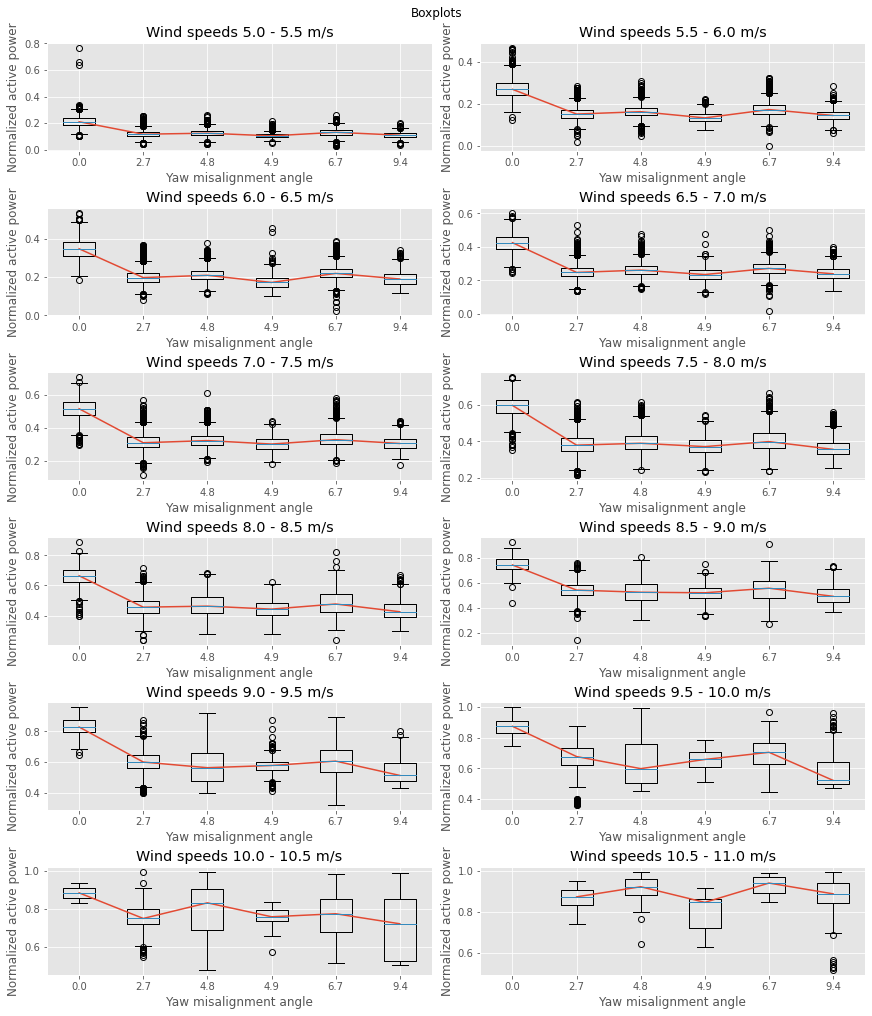

In [10]:
#code for boxplots
if len(binned_data_dfs) > 1:
    fig, axes = plt.subplots(nrows=int(len(binned_data_dfs)/2), ncols=2, figsize=(12,14), constrained_layout=True)
    axes = axes.ravel()
else:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,14), constrained_layout=True)
    axes = [axes]
plt.suptitle(f'Boxplots')

all_angles = []
dict_bin_dfs = {} 
for t, df_scaled in df_scaled_dict.items():
    df_scaled['y'] = np.abs(df_dict[t]['y']) # use the absolute value of the non-scaled df
    static_misalignment_values = df_angles_dict[t]
  

    binned_data_dfs = []

    for b in df_bin_masks[t]:
        df_temp = df_scaled[b]
        binned_data_dfs.append(df_temp.copy())
    dict_bin_dfs[t] = binned_data_dfs
        
box_plot_dict = {}
for bin_n in range(0, len(binned_data_dfs)):
    box_plot_dict[bin_n] = {}
    box_plot_dict[bin_n]['bin_data'] = {}
    box_plot_dict[bin_n]['medians'] = {}
    
for t, dict_bin_df in dict_bin_dfs.items():
    static_misalignment_values = df_angles_dict[t]
    angles = np.abs(np.unique(static_misalignment_values))
    for bin_n, d in enumerate(dict_bin_df):
        for theta_s in angles:
            d['y'] = np.abs(d['y'])
            df_temp = d[d['y'] == theta_s].copy()
            median = df_temp['active power'].median()
            box_plot_dict[bin_n]['medians'][theta_s] = median
            values = df_temp['active power'].values
            box_plot_dict[bin_n]['bin_data'][theta_s] = values
            
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
for bin_n in range(0, len(binned_data_dfs)):
    medians = [np.nan]
    bin_data = []
    values = box_plot_dict[bin_n]
    angles = list(values['bin_data'].keys())
    angles = sorted([float(x) for x in angles])
    labels = [str(l) for l in angles]
    for a in angles:
        medians.append(values['medians'][a])
        bin_data.append(values['bin_data'][a])
    ax = axes[bin_n] 
    ax.set_title(f'Wind speeds {bins[bin_n]} - {bins[bin_n + 1]} m/s')
    ax.boxplot(bin_data, showfliers=True)
    ax.plot(medians)
    locs = ax.get_xticks()
    ax.set_ylabel('Normalized active power')
    ax.set_xlabel('Yaw misalignment angle')
    ax.set_xticklabels(labels)
plt.show()
